#### Method 1
- Customisable cropping
- Destaggered/rectilinear grid e.g. after using `pp_concat_regrid.py` on WRFChem output with Salem to destagger and XEMSF to regrid to rectilinear grid

In [ ]:
import numpy as np
import xarray as xr
import geopandas as gpd
from cutshapefile import transform_from_latlon, rasterize

In [17]:
# single multipolygon
shapefile = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/CHN_adm0.shp')
shapes = [(shape, index) for index, shape in enumerate(shapefile.geometry)]

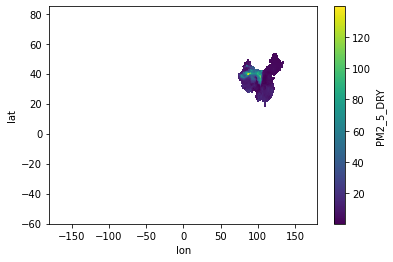

In [18]:
# using regridded file (xemsf)
ds = xr.open_dataset(
    '/nfs/b0122/Users/earlacoa/shared/nadia/wrfout_d01_global_0.25deg_2015-06_PM2_5_DRY_nadia.nc'
)['PM2_5_DRY'].mean(dim='time')

# apply shapefile to geometry, default: inside shapefile == 0, outside shapefile == np.nan
ds['shapefile'] = rasterize(shapes, ds.coords, longitude='lon', latitude='lat') 

# change to more intuitive labelling of 1 for inside shapefile and np.nan for outside shapefile
# if condition preserve (outside shapefile, as inside defaults to 0), otherwise (1, to mark in shapefile)
ds['shapefile'] = ds.shapefile.where(cond=ds.shapefile!=0, other=1) 

# example: crop to shapefile
# if condition (inside shapefile) preserve, otherwise (outside shapefile) remove
ds = ds.where(cond=ds.shapefile==1, other=np.nan) # could scale instead with other=ds*scale

ds.plot()

#### Method 2
- Cropping only
- Destaggered/rectilinear grid e.g. after using `pp_concat_regrid.py` on WRFChem output with Salem to destagger and XEMSF to regrid to rectilinear grid

In [ ]:
import xarray as xr
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping

In [19]:
shapefile = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/CHN_adm0.shp', crs="epsg:4326")

In [20]:
ds = xr.open_dataset(
    '/nfs/b0122/Users/earlacoa/shared/nadia/wrfout_d01_global_0.25deg_2015-06_PM2_5_DRY_nadia.nc'
)['PM2_5_DRY'].mean(dim='time')

In [21]:
ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
ds.rio.write_crs("epsg:4326", inplace=True)
ds_clipped = ds.rio.clip(shapefile.geometry.apply(mapping), shapefile.crs, drop=False)

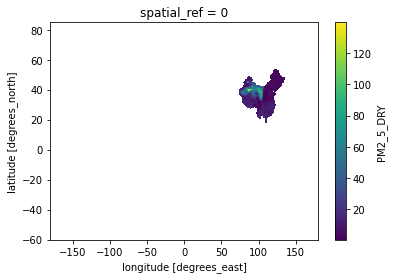

In [22]:
ds_clipped.plot()

#### Method 3
- Staggered grid
  - [WRFChem projection](https://fabienmaussion.info/2018/01/06/wrf-projection/) is normally on a [Arakawa-C Grid](https://xgcm.readthedocs.io/en/latest/grids.html)
  - e.g. intermediate WRFChem files that need to be reused (wrfiobiochemi)
  - e.g. raw wrfout file (after postprocessing) still on Arakawa-C Grid (2D lat/lon coordinates)

In [ ]:
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd # ensure version > 0.8.0

In [ ]:
# WARNING: the double for loop of geometry creation and checking is very slow
# the mask in the cell below has already been calculated
ds = xr.open_dataset('/nfs/b0122/Users/earlacoa/shared/nadia/wrfbiochemi')['MSEBIO_ISOP']
shapefile = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/CHN_adm0.shp')
mask = np.empty([ds.south_north.shape[0], ds.west_east.shape[0]])
mask[:] = np.nan

for index_lat in range(ds.south_north.shape[0]):
    for index_lon in range(ds.west_east.shape[0]):
        lat = ds.isel(south_north=index_lat).isel(west_east=index_lon).XLAT.values[0]
        lon = ds.isel(south_north=index_lat).isel(west_east=index_lon).XLONG.values[0]

        point_df = pd.DataFrame({'longitude': [lon], 'latitude': [lat]})
        point_geometry = gpd.points_from_xy(point_df.longitude, point_df.latitude, crs="EPSG:4326")
        point_gdf = gpd.GeoDataFrame(point_df, geometry=point_geometry)

        point_within_shapefile = point_gdf.within(shapefile)[0]
        
        if point_within_shapefile:
            mask[index_lat][index_lon] = True

In [26]:
# bring in mask which computed earlier
ds = xr.open_dataset('/nfs/b0122/Users/earlacoa/shared/nadia/wrfbiochemi')
mask = np.load('/nfs/b0122/Users/earlacoa/shared/nadia/mask_china.npz')['mask']

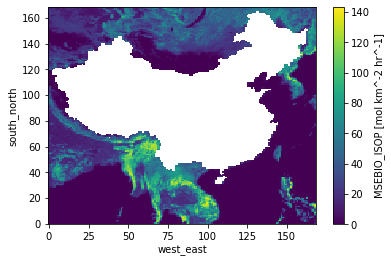

In [27]:
# demo - removing values in mask
demo = ds['MSEBIO_ISOP'].where(cond=mask!=True, other=np.nan)
demo.plot()

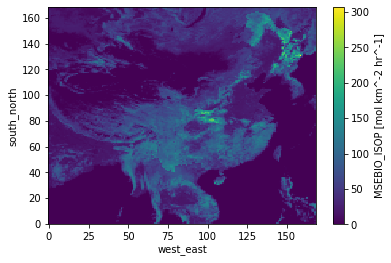

In [28]:
# example - doubling isoprene emissions within mask
ds['MSEBIO_ISOP'] = ds['MSEBIO_ISOP'].where(cond=mask!=True, other=2*ds['MSEBIO_ISOP'])
ds['MSEBIO_ISOP'].plot()

In [29]:
# saving back into dataset
ds.to_netcdf('/nfs/b0122/Users/earlacoa/shared/nadia/wrfbiochemi_double_isoprene_china')

In [30]:
# check that doubling persisted
ds_original = xr.open_dataset('/nfs/b0122/Users/earlacoa/shared/nadia/wrfbiochemi')['MSEBIO_ISOP']
ds_double = xr.open_dataset('/nfs/b0122/Users/earlacoa/shared/nadia/wrfbiochemi_double_isoprene_china')['MSEBIO_ISOP']

In [33]:
fraction = ds_double / ds_original

In [35]:
print(fraction.max().values)
print(fraction.min().values)
print(fraction.mean().values)

2.0
1.0
1.4608158
